# Exercise 1: Optimize lepton selection

* First, print the distributions of the relevant variables for *all* the Monte Carlo samples (i.e. all the *channels* of the $Z$-boson decay to be studied). Which variables are these? Give sensible ranges to include all the events in the samples (both MC and OPAL data) 
* Do the same for **one** of the OPAL data samples (your lab assistant will decide which one you choose).
* Describe the results.
* Optimize the object selection by applying cuts. Make a strategy on how to proceed to find the optimal selection. which information do you need?
* Determine the efficiency and the amount of background for each $Z$ decay channel. Use the simulated events $e^+e^-$, $\mu^+\mu^-$, $\tau^+\tau^-$ and hadrons ($qq$). Represent the result in a matrix form and think carefully about how you have to correct the measured rates. Don't forget to calculate the errors!
* How do we estimate the statistical fluctuations per bin?

#### Import libraries

In [1]:
import uproot
import awkward as ak
import mplhep
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt

#### Load the data

In [39]:
### Specify the folder path for MC samples
path_data = 'data/'

### Open the file introducing file path
mc_data_ee = uproot.open(path_data+'ee.root')
mc_data_mm = uproot.open(path_data+'mm.root')
mc_data_qq = uproot.open(path_data+'qq.root')
mc_data_tt = uproot.open(path_data+'tt.root')
ttree_name = 'myTTree'

### Print list of 'branches' of the TTree (i.e. list of variable names)
mc_data_ee[ttree_name].keys()
#print(mc_data_ee[ttree_name].keys())

### Load branches
branches_ee = mc_data_ee[ttree_name].arrays()
branches_mm = mc_data_mm[ttree_name].arrays()
branches_qq = mc_data_mm[ttree_name].arrays()
branches_tt = mc_data_mm[ttree_name].arrays()

### List of variables (of interest)
vars=['Pcharged', 'Ncharged', 'E_ecal', 'E_hcal']

###
# pchar_ee= ak.to_numpy(branches_ee[vars[0]])
# nchar_ee=ak.to_numpy(branches_ee[vars[1]])
# e_ecal_ee=ak.to_numpy(branches_ee[vars[2]])
# e_hcal_ee=ak.to_numpy(branches_ee[vars[3]])

# pchar_mm= ak.to_numpy(branches_mm[vars[0]])
# nchar_mm=ak.to_numpy(branches_mm[vars[1]])
# e_ecal_mm=ak.to_numpy(branches_mm[vars[2]])
# e_hcal_mm=ak.to_numpy(branches_mm[vars[3]])

# pchar_qq= ak.to_numpy(branches_qq[vars[0]])
# nchar_qq=ak.to_numpy(branches_qq[vars[1]])
# e_ecal_qq=ak.to_numpy(branches_qq[vars[2]])
# e_hcal_qq=ak.to_numpy(branches_qq[vars[3]])

# pchar_tt= ak.to_numpy(branches_tt[vars[0]])
# nchar_tt=ak.to_numpy(branches_tt[vars[1]])
# e_ecal_tt=ak.to_numpy(branches_tt[vars[2]])
# e_hcal_tt=ak.to_numpy(branches_tt[vars[3]])




# print(f"Array of type '{type(pchar_qq)}' defined for '{vars[0]}' for hadrons:\n{pchar_qq}")
# print(pchar_qq.max())
# print(pchar_qq.min())
# print(pchar_qq.size)
# print(pchar_qq.mean())
# print(pchar_qq.std())

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 93802 and the array at index 1 has size 94381

Choose bin width with scotts rule: bin width $\Delta b = \frac{3.5 \sigma}{n}$. Where $n$ is the size of the array.

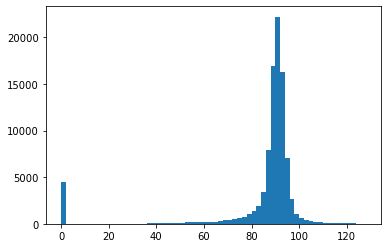

In [12]:
plt.hist(pchar_qq,bins=np.arange(,2));
plt.show()

In [25]:
labels=['r$Z^0$ $\to$ hadrons',r'$Z^0$ $\to$ $e^+e^-$',r'$Z^0$ $\to$ $\mu^+\mu^-$',r'$Z^0$ $\to$ $\tau^+\tau^-$']
bin_widths=np.zeros(4)
for i in np.arange(4):
    bin_widths[i]=3.5*ak.to_numpy(branches_qq[vars[0]]).std()/ak.to_numpy(branches_qq[vars[0]])

In [37]:
a=np.array([1,2,3])
b=np.array([4,5,6])
c=np.row_stack((a,b))
print(c)
print(c[0])

[[1 2 3]
 [4 5 6]]
[1 2 3]
